# Predicting Seasonal Flu Vaccines
Aung Si<br>
August 19<sup>th</sup>, 2023

---

## Contents

1. [Introduction](#introduction)
2. [The Data](#the-data)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Loading The Data](#loading-the-data)
    - [Choosing Our Target](#choosing-our-target)
    - [Handling Nulls](#handling-nulls)
    - [Examining Feature Correlations](#examining-feature-correlations)
3. [Preparing for Model Building](#preparing-for-model-building)

---

## Introduction 

Vaccines have long been a cornerstone of public health, shielding individuals and entire communities from a wide array of infectious diseases. Among these, the ongoing efforts to immunize against seasonal influenza stand out as a vital and complex undertaking. Unlike specific pandemic strains such as the 2009 H1N1 "swine flu," seasonal flu is a persistent and annually recurring challenge, necessitating vigilance and adaptation by medical professionals every year. Seasonal influenza vaccines are developed and distributed on an annual basis to combat the most common flu strains predicted to circulate during the upcoming flu season. Scientists and researchers analyze global flu trends, collecting samples and data to determine which strains are most likely to pose a threat. The composition of the seasonal flu vaccine is then tailored each year based on these predictions, making it a unique and dynamic tool in the fight against influenza.

In the United States, a coordinated effort involving the government, healthcare providers, public health organizations, and even private companies is launched each year to promote and provide seasonal flu vaccines. This expansive campaign includes public education, accessibility initiatives, and collaboration with healthcare professionals to ensure that vaccines reach as many people as possible. Guiding these efforts are robust data collection and analysis, including surveys and studies that closely monitor vaccination rates. One such resource is the National Seasonal Flu Survey, a comprehensive effort to gather information about individuals' vaccination status, as well as insights into their lives, opinions, and behaviors related to vaccination. In this analysis, we will delve into the data from this survey, applying statistical and analytical techniques to uncover patterns and trends in seasonal flu vaccination. By understanding the factors that influence people's decisions to get vaccinated, such as age, location, education, and beliefs about vaccines, we can craft targeted strategies to increase vaccination rates.

## The Data

The dataset utilized in this project originates from the National 2009 H1N1 Flu Survey (NHFS), conducted during the 2009-10 flu season. This telephone survey was designed to monitor influenza immunization coverage in the United States, specifically targeting individuals aged 6 months or older. A collaboration between the National Center for Immunization and Respiratory Diseases (NCIRD) and the National Center for Health Statistics (NCHS) under the Centers for Disease Control and Prevention (CDC), the NHFS collected information from October 2009 to June 2010. Its primary focus was to produce timely estimates of vaccination coverage rates for both the monovalent pH1N1 and trivalent seasonal influenza vaccines during the 2009-2010 flu season in response to the H1N1 pandemic. The CDC continues to monitor seasonal flu vaccination through other ongoing annual phone surveys, but the NHFS stands as a one-time survey created for this specific purpose.

For our exploration we're given three CSV's:
1. **Training Labels**: This one holds the binary labels we'll be training our model(s) to predict. There are two target labels, `'h1n1_vaccine'` and '`seasonal_vaccine'`— for this analysis we're only concerned with the latter. A $0$ indicates that the given respondent did not receive the respective vaccine while a $1$ indicates that the given respondent received the respective vaccine. This file shares the `'respondent_id'` column with the Training Features CSV.

2. **Training Features**: These are the features we'll be using to predict the probability of a respondent receiving a vaccine. There are 35 features and each is a response to a survey question. Features comprise various topics, such as behavioral (whether a respondent touches their face, washes their hand, etc.), opinion (whether the respondent believed the h1n1 vaccine was effective, etc.), and demographic.

3. **Testing Features**: These features relate to the respondents for whom we will be predicting the likelihood of receiving the vaccine.

Let's go ahead and import the necessary imports and load in our data so that we can start cleaning it.

## Exploratory Data Analysis

### Loading the Data

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Load in data
train_features = pd.read_csv('data/training_set_features.csv')
train_labels = pd.read_csv('data/training_set_labels.csv')
test_features = pd.read_csv('data/test_set_features.csv')

train_df = pd.merge(train_labels, train_features, on='respondent_id')
train_df.set_index('respondent_id', inplace=True)

In the above, we've merged our training features and training labels into one big dataset, `'train_df'`. The choice to do this also means that we can use the binary value for `'h1n1_vaccine'` as a feature. So scratch what I said earlier - we actually have <u>36</u> features to train our models with. Note that we've also set our index to be `'respondent_id'` so as to not accidentally use it as feature.

In [36]:
# Examine the dataset's shape
print(f'train_df.shape: {train_df.shape}')

train_df.shape: (26707, 37)


In [37]:
train_df.head(3)

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


Consistent with the problem description page, we can see that almost all of our features are categorical, save for a few. However, there are still some mismatches in representation, but we'll deal with them in a later portion of our analysis.

In [38]:
# Examine the dataset's datatypes
train_df.dtypes

h1n1_vaccine                     int64
seasonal_vaccine                 int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                     

### Choosing our target

We're given two targets - `'h1n1_vaccine'`, and `'seasonal_vaccine'`. However, to scope it down to a single-target classification problem, we'll keep just one. We'll keep whichever one has better class-balance; that is, whichever one has a more even spread between $0$ 's and $1$ 's.

In [39]:
# Examine the vaccination value counts
for vaccine in ['seasonal_vaccine', 'h1n1_vaccine']:
    print(train_df[vaccine].value_counts())

# Given that seasonal vaccine has a better class balance, we'll choose that as our target

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


Given that seasonal vaccine has a better class balance, we'll choose that as our target.

### Handling Nulls

In [40]:
train_df.isnull().sum()

h1n1_vaccine                       0
seasonal_vaccine                   0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
i

It seems we have a fair amount of null values within our dataset to handle. It's easy to drop all entries with null values, but this might be reckless. Instead, we'll get rid of features with $>30\%$ null values (unless we deem them important to our analysis), and handle the rest later.

In [41]:
missing_data = train_df.isnull().sum()
missing_data_pct = missing_data / len(train_df)
missing_data_pct[missing_data_pct > .3]

health_insurance         0.459580
employment_industry      0.499120
employment_occupation    0.504362
dtype: float64

The following features seem to have more than 30% null values:
- `health_insurance` $(46\%)$
- `employment_industry` $(50\%)$
- `employment_occupation` $(50\%)$

The latter two have encoded values that aren't interpretable (nor does the CDC provide instruction on how to decode them), so we'll go ahead and drop those two. For `'health_insurance'`: health insurance data is usually available for people who have it, so for this analysis we'll replace the `NaN` values with 0s. Essentially, we deem respondents with missing health insurance data as lacking insurance.

In [42]:
train_df['health_insurance'].fillna(0, inplace=True)
train_df.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)
train_df.shape

(26707, 35)

Now we've gotten rid of two of our 36 features, leaving us still with 34 to work with!

### Reconciling Datatypes

Though our data is mostly categorical, there are still inconsistencies within how these categorical datapoints are represented—namely, there are some string representations amongst the majority, which is represented by either floats or integers—so we'll have to address those.

In [43]:
string_representations = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
string_representations

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

The above columns are represented in string format. We'll need to use One Hot Encoding to convert those into floats / integers.

In [44]:
train_df_encoded = pd.get_dummies(train_df, columns=string_representations)
encoded_columns = [col for col in train_df_encoded.columns if any(col.startswith(str_col) for str_col in string_representations)]
train_df_encoded[encoded_columns].dtypes

age_group_18 - 34 Years                     uint8
age_group_35 - 44 Years                     uint8
age_group_45 - 54 Years                     uint8
age_group_55 - 64 Years                     uint8
age_group_65+ Years                         uint8
education_12 Years                          uint8
education_< 12 Years                        uint8
education_College Graduate                  uint8
education_Some College                      uint8
race_Black                                  uint8
race_Hispanic                               uint8
race_Other or Multiple                      uint8
race_White                                  uint8
sex_Female                                  uint8
sex_Male                                    uint8
income_poverty_<= $75,000, Above Poverty    uint8
income_poverty_> $75,000                    uint8
income_poverty_Below Poverty                uint8
marital_status_Married                      uint8
marital_status_Not Married                  uint8


In [45]:
train_df_encoded.shape

(26707, 63)

Now that we've encoded some features, we've almost doubled our feature set - this can lead to even more multicollinearity, which is something we have to be cognizant of when building our models!

### Examining Feature Correlations

Before modeling, we need to check the correlations among our features. In classification as in regressions, this is key. If two features are highly correlated, we might remove one to reduce redundancy. If two features are moderately correlated but convey different information, we might keep both and consider regularization. This step helps avoid issues like noise and overfitting, making the model more robust and interpretable.

Let's start with looking at the five most correlated features.

In [51]:
corr_mat = train_df_encoded.corr()
corr_mat[corr_mat == 1] = np.nan
five_most_correlated = corr_mat.unstack().sort_values(
    ascending=False
).drop_duplicates()[:5]

print(five_most_correlated)

doctor_recc_seasonal         doctor_recc_h1n1                        0.591868
behavioral_outside_home      behavioral_large_gatherings             0.584085
opinion_seas_risk            opinion_h1n1_risk                       0.564208
age_group_65+ Years          employment_status_Not in Labor Force    0.498880
opinion_h1n1_sick_from_vacc  opinion_seas_sick_from_vacc             0.491546
dtype: float64


It appears that there is a significant correlation between features mirroring the responses related to seasonal vaccines and their corresponding counterparts for the H1N1 vaccine. This pattern suggests a parallelism in perceptions and behaviors concerning both types of vaccines, reflecting a good amount of consistency in respondents' attitudes and practices. Now let's take a look at the correlation matrix for the entirety of our feature set:

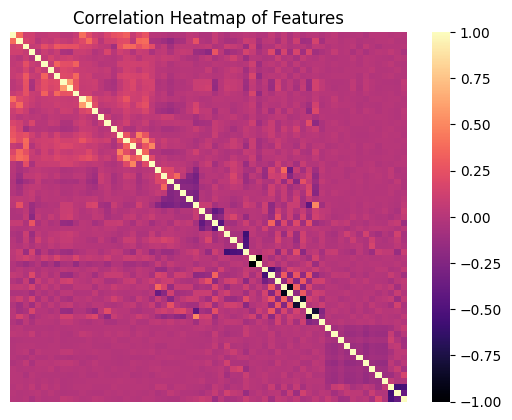

In [54]:

sns.heatmap(train_df_encoded.corr(), cmap='magma')
plt.title('Correlation Heatmap of Features')
plt.xticks([])
plt.yticks([]);

The majority of our features are only moderately correlated, which is a good sign for our models. However, there are still some high-positive-correlation features, but we can address these through regularization!

## Preparing for Model Building

Before we start building our models, we need to deal with the remaining missing data points. So far, we've only removed features with too many null values. To fill in the rest, we can use `SimpleImputer` from `sklearn.impute`, but we have to be careful: we don't want any data leakage from our validation set. If we were to impute before splitting, information from the validation set could influence the training data. By handling missing values after the split, we ensure a fair and accurate evaluation of our models.

For our train-test splitting, we'll keep $70\%$ of our data as training, and use the remainder $30\%$ as our validation set.

In [162]:
from sklearn.model_selection import train_test_split

target = 'seasonal_vaccine' # We want to predict seasonal vaccine

X = train_df_encoded.drop(columns=target)
y = train_df_encoded[target]

seed = 42 # For reproducability
test_size = .3 # 30% of our data will be in the validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18694, 62), (8013, 62), (18694,), (8013,))

Now that we've split our data, we can use `SimpleImputer`. We'll factor this into a function so we can do this on both the training and validation datasets. Since our data is represented by discrete numerics, we'll use the mode to fill in the null values.

In [163]:
from sklearn.impute import SimpleImputer

def simple_impute(*Xs):
    results = []
    imputer = SimpleImputer(strategy='most_frequent')
    for X in Xs:
        X_imputed = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
        results.append(X_imputed)
    return tuple(results)

In [164]:
X_train, X_test = simple_impute(X_train, X_test)

print(f'Null values in X_train: {X_train.isnull().sum().sum()}')
print(f'Null values in X_test: {X_test.isnull().sum().sum()}')

Null values in X_train: 0
Null values in X_test: 0


We've successfully handled all the missing values in our input datasets - both for training and validation. However, we haven't checked if our target, `y`, has any missing values. Let's quickly do that:

In [165]:
print(f'Null values in y_train: {y_train.isnull().sum().sum()}')
print(f'Null values in y_test: {y_test.isnull().sum().sum()}')

Null values in y_train: 0
Null values in y_test: 0


Great, we have no null values in `y`. We can now get to building our models!

## Building Models

One last thing to address before we dive into modeling - our input features are on different scales. To level the playing field, we'll use `StandardScaler` from sklearn to scale our features uniformly. With that in place, we're ready to build some models to predict whether a respondent gets their seasonal flu vaccine.

We'll kick things off with a simple baseline: a logistic regression model. It's a good starting point, and we'll evaluate it based on accuracy, F1 score, and the ROC curve. From there, we can refine it or explore other models to improve our predictions, and we'll keep at it until we're satisfied with the results.

To streamline this process, we'll bundle these steps into a pipeline. And to keep everything organized, we'll store our pipelines in a dictionary. That way, we can easily track and compare the models we've used. Let's get started with defining a function to create, train, and evaluate different machine learning models within a pipeline structure. This function will allow us to easily compare the performance of different models and detect overfitting or underfitting by comparing training and test scores.

In [166]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, accuracy_score, f1_score

def run_pipeline(pipeline, stats_df, X_train, X_test, y_train, y_test, index):
    # Fit pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate on training data
    y_train_pred = pipeline.predict(X_train)
    y_train_pred_proba = pipeline.predict_proba(X_train)[:, 1]
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    
    # Predict and evaluate on test data
    y_test_pred = pipeline.predict(X_test)
    y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    stats = {
        'Name': list(pipeline.named_steps.keys())[1],
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Train ROC': train_auc,
        'Test ROC': test_auc
    }
    
    stats_df.loc[index] = stats
    return stats_df

pipelines = {}

stats_df = pd.DataFrame({
    'Name': [], 
    'Train Accuracy': [], 'Test Accuracy': [], 
    'Train F1': [], 'Test F1': [],
    'Train ROC': [], 'Test ROC': []
})

stats_df.index.name = 'Model'

### Baseline Model - Logistic Regression

In [167]:
from sklearn.linear_model import LogisticRegression

model_name_1 = 'Baseline Model'

base_pipeline = Pipeline([
        ('standard_scaler', StandardScaler()),
        (model_name_1, LogisticRegression(random_state=seed))
    ])

pipelines[model_name_1] = base_pipeline

stats_df = run_pipeline(
    pipelines[model_name_1], 
    stats_df, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    1
)

stats_df

,Name,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
Model,,,,,,,
1,Baseline Model,0.797154,0.804318,0.776757,0.780515,0.873858,0.87567


In [168]:
baseline_coefs = pd.DataFrame(
    pipelines[model_name_1].named_steps[model_name_1].coef_, 
    columns=X_train.columns
).T

baseline_coefs = baseline_coefs.rename(
    columns={0: 'Coefficients'}
).sort_values(
    by='Coefficients', ascending=False
)

baseline_coefs[:10]

,Coefficients
h1n1_vaccine,0.797551
doctor_recc_seasonal,0.738735
opinion_seas_risk,0.715701
opinion_seas_vacc_effective,0.637131
age_group_65+ Years,0.385345
health_worker,0.191164
education_College Graduate,0.121506
behavioral_touch_face,0.107308
health_insurance,0.100387
chronic_med_condition,0.086786


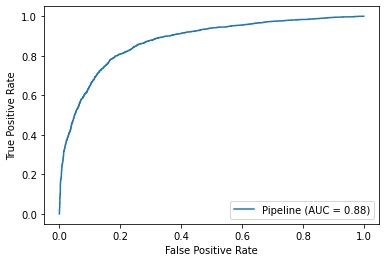

In [169]:
plot_roc_curve(base_pipeline, X_test, y_test)
plt.show()

In [170]:
from sklearn.tree import DecisionTreeClassifier

model_name_2 = 'Decision Tree'

dt_pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    (model_name_2, DecisionTreeClassifier(random_state=seed))
])

pipelines[model_name_2] = dt_pipeline

stats_df = run_pipeline(
    pipelines[model_name_2], 
    stats_df, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    2
)

stats_df

,Name,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
Model,,,,,,,
1,Baseline Model,0.797154,0.804318,0.776757,0.780515,0.873858,0.875670
2,Decision Tree,1.000000,0.713216,1.000000,0.690046,1.000000,0.711949


In [171]:
dt_fi = pd.DataFrame(
    pipelines[model_name_2].named_steps[model_name_2].feature_importances_, 
    index=X_train.columns
)

dt_fi = dt_fi.rename(
    columns={0: 'Importance'}
).sort_values(
    by='Importance', ascending=False
)

dt_fi[:10]

,Importance
h1n1_vaccine,0.143598
opinion_seas_vacc_effective,0.112919
doctor_recc_seasonal,0.054243
opinion_seas_risk,0.052087
opinion_seas_sick_from_vacc,0.028968
opinion_h1n1_vacc_effective,0.028871
opinion_h1n1_sick_from_vacc,0.027374
age_group_18 - 34 Years,0.026227
opinion_h1n1_risk,0.025027
doctor_recc_h1n1,0.023939


### Model 3 - Random Forest Classifier

In [172]:
from sklearn.ensemble import RandomForestClassifier

model_name_3 = 'Random Forest'

rf_pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    (model_name_3, RandomForestClassifier(random_state=seed))
])

pipelines[model_name_3] = rf_pipeline

stats_df = run_pipeline(pipelines[model_name_3], stats_df, X_train, X_test, y_train, y_test, 3)
stats_df

,Name,Train Accuracy,Test Accuracy,Train F1,Test F1,Train ROC,Test ROC
Model,,,,,,,
1,Baseline Model,0.797154,0.804318,0.776757,0.780515,0.873858,0.875670
2,Decision Tree,1.000000,0.713216,1.000000,0.690046,1.000000,0.711949
3,Random Forest,1.000000,0.799326,1.000000,0.777716,1.000000,0.873023


In [173]:
rf_fi = pd.DataFrame(
    pipelines[model_name_3].named_steps[model_name_3].feature_importances_,
    index=X_train.columns
)

rf_fi = rf_fi.rename(
    columns={0: 'Importance'}
).sort_values(
    by='Importance', ascending=False
)

rf_fi[:10]

,Importance
opinion_seas_vacc_effective,0.087252
opinion_seas_risk,0.073826
h1n1_vaccine,0.072360
doctor_recc_seasonal,0.064513
opinion_h1n1_risk,0.033688
opinion_h1n1_vacc_effective,0.030559
age_group_65+ Years,0.028890
opinion_seas_sick_from_vacc,0.028123
h1n1_concern,0.026048
opinion_h1n1_sick_from_vacc,0.025996
